Overall Average Monthly Return: 0.7217366255144032
Final Weights, Returns, Standard Deviations, Mean Returns, and Covariance Matrix for Each Strategy and Window:
   Window          Strategy  \
0      48     Mean-Variance   
1      48  Minimum-Variance   
2      48             Naive   
3      96     Mean-Variance   
4      96  Minimum-Variance   
5      96             Naive   
6     144     Mean-Variance   
7     144  Minimum-Variance   
8     144             Naive   

                                        Mean Returns  \
0  {'SMALL LoINV': 1.2358333333333333, 'ME1 INV2'...   
1  {'SMALL LoINV': 1.2358333333333333, 'ME1 INV2'...   
2  {'SMALL LoINV': 1.2358333333333333, 'ME1 INV2'...   
3  {'SMALL LoINV': 0.5962499999999998, 'ME1 INV2'...   
4  {'SMALL LoINV': 0.5962499999999998, 'ME1 INV2'...   
5  {'SMALL LoINV': 0.5962499999999998, 'ME1 INV2'...   
6  {'SMALL LoINV': 0.678611111111111, 'ME1 INV2':...   
7  {'SMALL LoINV': 0.678611111111111, 'ME1 INV2':...   
8  {'SMALL LoINV': 0.67

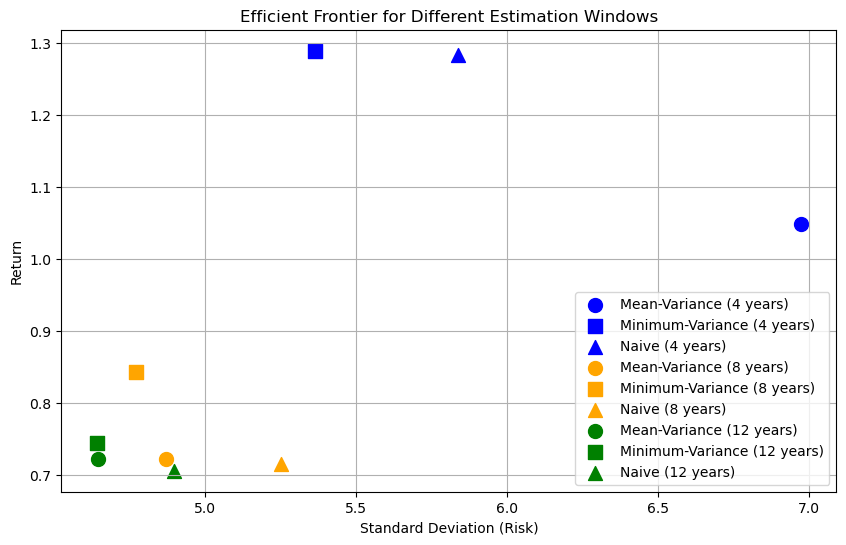

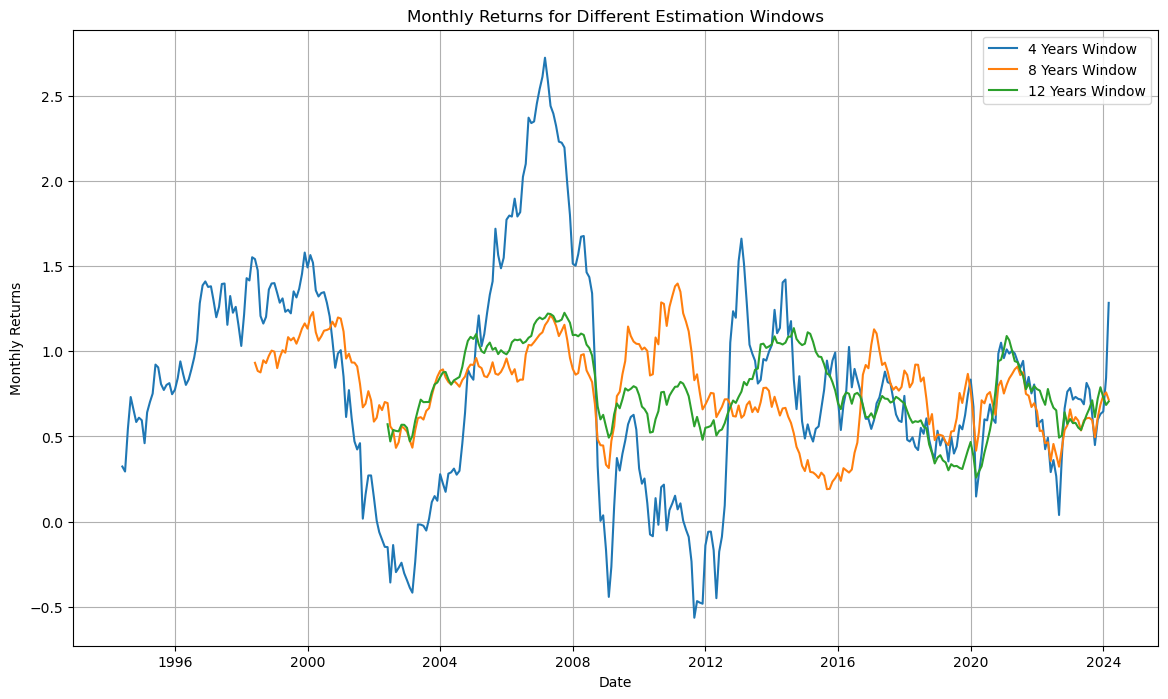

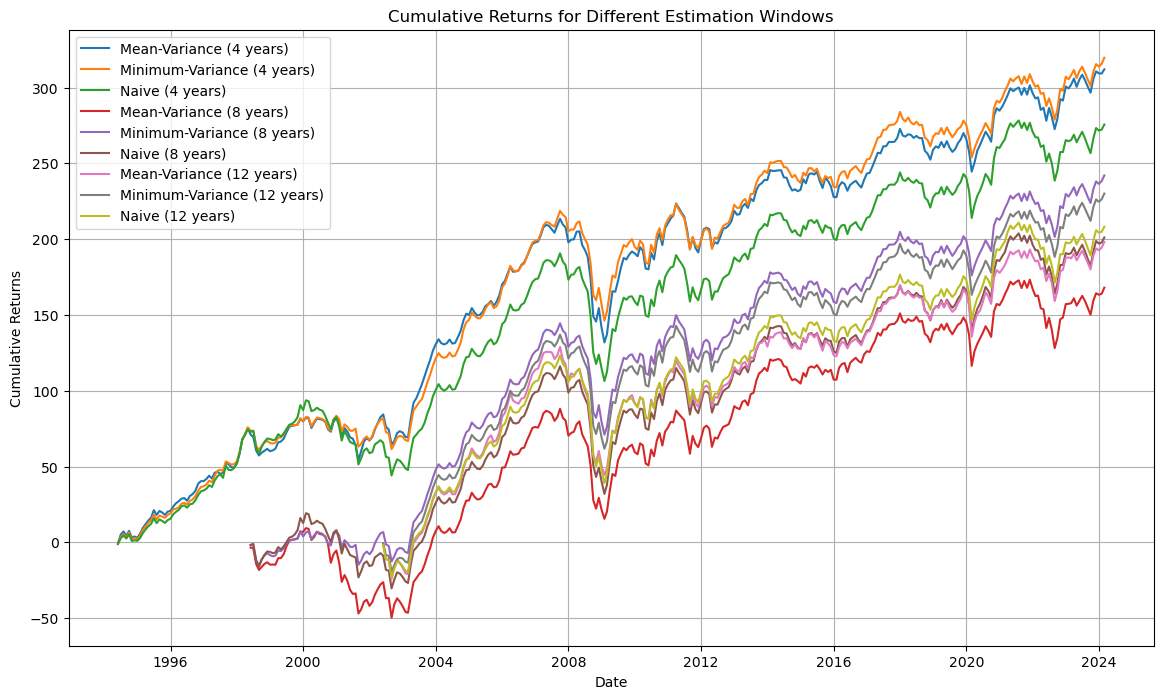

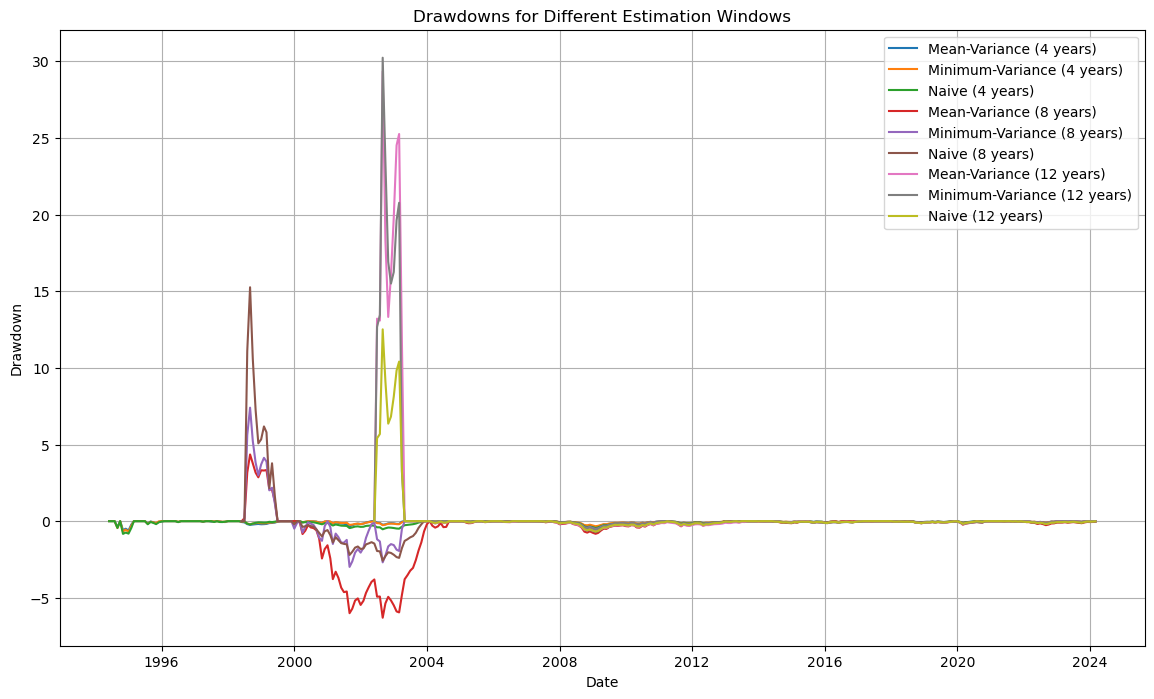

In [44]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'Europe_6_Portfolios_ME_INV.csv'
data = pd.read_csv(file_path, skiprows=range(0, 19), names=['Date', 'SMALL LoINV', 'ME1 INV2', 'SMALL HiINV', 'BIG LoINV', 'ME2 INV2', 'BIG HiINV'], nrows=405)

# Clean the data
data['Date'] = data['Date'].astype(str)
data = data[data['Date'].str.match(r'^\d{6}$', na=False)]
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m')
for col in data.columns[1:]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Set the index to 'Date'
data.set_index('Date', inplace=True)

# Helper function to calculate rolling mean and covariance matrix
def rolling_estimate_parameters(data, window):
    rolling_mean_returns = data.rolling(window=window).mean().dropna()
    rolling_cov_matrix = data.rolling(window=window).cov().dropna()
    return rolling_mean_returns, rolling_cov_matrix

# Function to solve mean-variance optimization for a given target return
def mean_variance_optimization(mean_returns, cov_matrix, target_return):
    num_assets = len(mean_returns)
    
    def portfolio_return(weights):
        return np.dot(weights, mean_returns)
    
    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    def objective_function(weights):
        return portfolio_volatility(weights)
    
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                   {'type': 'eq', 'fun': lambda weights: portfolio_return(weights) - target_return})
    
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets,]
    
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

# Helper function to solve minimum-variance optimization
def minimum_variance_optimization(cov_matrix):
    num_assets = len(cov_matrix)
    
    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    def objective_function(weights):
        return portfolio_volatility(weights)
    
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets,]
    
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

# Estimation windows in months
windows = [12*4, 12*8, 12*12]  # 4 years, 8 years, 12 years

# Calculate the average return for each portfolio over the entire dataset
portfolio_averages = data.mean(axis=1)

# Calculate the overall average return across all 25 portfolios for each monthly date
overall_average_return = portfolio_averages.mean()

# Print the overall average monthly return
print(f"Overall Average Monthly Return: {overall_average_return}")

# Save the overall average monthly return to a CSV file
overall_average_return_df = pd.DataFrame({'Overall Average Monthly Return': [overall_average_return]})

target_return = overall_average_return  # target return according to the average of monthly return of the dataset

# Loop through each estimation window
results = {}
for window in windows:
    mean_returns, cov_matrix = rolling_estimate_parameters(data, window)
    
    mv_weights_all = []
    min_var_weights_all = []
    dates = mean_returns.index
    
    for i in range(len(mean_returns)):
        mean_ret = mean_returns.iloc[i]
        cov_mat = cov_matrix.loc[mean_returns.index[i]]
        
        # Mean-variance optimization
        mv_weights = mean_variance_optimization(mean_ret, cov_mat, target_return)
        mv_weights_all.append(mv_weights)
        
        # Minimum-variance optimization
        min_var_weights = minimum_variance_optimization(cov_mat)
        min_var_weights_all.append(min_var_weights)
    
    results[window] = {
        'dates': dates,
        'mean_returns': mean_returns.iloc[-1],
        'cov_matrix': cov_matrix.iloc[-len(data.columns):, -len(data.columns):],
        'mv_weights': mv_weights_all,
        'min_var_weights': min_var_weights_all,
    }

# Function to calculate returns for naive portfolio
def naive_portfolio_weights(data):
    num_assets = data.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

# Calculate final weights and returns
final_results = []
for window in windows:
    last_mean_returns = data.rolling(window=window).mean().dropna().iloc[-1]
    last_cov_matrix = data.rolling(window=window).cov().dropna().iloc[-data.shape[1]:, -data.shape[1]:]
    
    mv_weights = mean_variance_optimization(last_mean_returns, last_cov_matrix, target_return)
    min_var_weights = minimum_variance_optimization(last_cov_matrix)
    naive_weights = naive_portfolio_weights(data)
    
    mv_return = np.dot(mv_weights, last_mean_returns)
    min_var_return = np.dot(min_var_weights, last_mean_returns)
    naive_return = np.dot(naive_weights, last_mean_returns)
    
    mv_std_dev = np.sqrt(np.dot(mv_weights.T, np.dot(last_cov_matrix, mv_weights)))
    min_var_std_dev = np.sqrt(np.dot(min_var_weights.T, np.dot(last_cov_matrix, min_var_weights)))
    naive_std_dev = np.sqrt(np.dot(naive_weights.T, np.dot(last_cov_matrix, naive_weights)))
    
    final_results.append({
        'Window': window,
        'Strategy': 'Mean-Variance',
        'Mean Returns': last_mean_returns.to_dict(),
        'Covariance Matrix': last_cov_matrix.values.tolist(),
        'Weights': mv_weights,
        'Return': mv_return,
        'Std Dev': mv_std_dev,
        'Sum of Weights': np.sum(mv_weights)
    })
    final_results.append({
        'Window': window,
        'Strategy': 'Minimum-Variance',
        'Mean Returns': last_mean_returns.to_dict(),
        'Covariance Matrix': last_cov_matrix.values.tolist(),
        'Weights': min_var_weights,
        'Return': min_var_return,
        'Std Dev': min_var_std_dev,
        'Sum of Weights': np.sum(min_var_weights)
    })
    final_results.append({
        'Window': window,
        'Strategy': 'Naive',
        'Mean Returns': last_mean_returns.to_dict(),
        'Covariance Matrix': last_cov_matrix.values.tolist(),
        'Weights': naive_weights,
        'Return': naive_return,
        'Std Dev': naive_std_dev,
        'Sum of Weights': np.sum(naive_weights)
    })

# Convert to DataFrame
final_results_df = pd.DataFrame(final_results)

# Save the final results to a CSV file
final_results_df.to_csv('optimal_portfolios_results.csv', index=False)

# Print the final results
pd.set_option('display.max_columns', None)  # To ensure all columns are printed
print("Final Weights, Returns, Standard Deviations, Mean Returns, and Covariance Matrix for Each Strategy and Window:")
print(final_results_df)

# Plotting Efficient Frontier
def plot_efficient_frontier(final_results_df):
    plt.figure(figsize=(10, 6))
    colors = {48: 'blue', 96: 'orange', 144: 'green'}
    markers = {'Mean-Variance': 'o', 'Minimum-Variance': 's', 'Naive': '^'}
    
    for window in final_results_df['Window'].unique():
        df_window = final_results_df[final_results_df['Window'] == window]
        for strategy in df_window['Strategy'].unique():
            strategy_data = df_window[df_window['Strategy'] == strategy]
            plt.scatter(strategy_data['Std Dev'], strategy_data['Return'], 
                        label=f'{strategy} ({window // 12} years)',
                        color=colors[window],
                        marker=markers[strategy],
                        s=100)  # Increased size for better visibility
    
    plt.xlabel('Standard Deviation (Risk)')
    plt.ylabel('Return')
    plt.title('Efficient Frontier for Different Estimation Windows')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot efficient frontier for each estimation window
plot_efficient_frontier(final_results_df)

# Function to plot monthly returns for each window
def plot_monthly_returns(data, windows):
    plt.figure(figsize=(14, 8))
    for window in windows:
        rolling_returns = data.rolling(window=window).mean().dropna()
        plt.plot(rolling_returns.index, rolling_returns.mean(axis=1), label=f'{window // 12} Years Window')
    
    plt.xlabel('Date')
    plt.ylabel('Monthly Returns')
    plt.title('Monthly Returns for Different Estimation Windows')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot monthly returns for each window
plot_monthly_returns(data, windows)

# Plot cumulative returns
def plot_cumulative_returns(results, windows):
    plt.figure(figsize=(14, 8))
    for window in windows:
        dates = results[window]['dates']
        mv_weights = results[window]['mv_weights']
        min_var_weights = results[window]['min_var_weights']
        
        mv_cumulative = np.cumsum([np.dot(w, data.loc[d]) for w, d in zip(mv_weights, dates)])
        min_var_cumulative = np.cumsum([np.dot(w, data.loc[d]) for w, d in zip(min_var_weights, dates)])
        naive_weights = naive_portfolio_weights(data)
        naive_cumulative = np.cumsum([np.dot(naive_weights, data.loc[d]) for d in dates])
        
        plt.plot(dates, mv_cumulative, label=f'Mean-Variance ({window // 12} years)')
        plt.plot(dates, min_var_cumulative, label=f'Minimum-Variance ({window // 12} years)')
        plt.plot(dates, naive_cumulative, label=f'Naive ({window // 12} years)')
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns for Different Estimation Windows')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot cumulative returns for each estimation window
plot_cumulative_returns(results, windows)

# Function to calculate drawdowns
def calculate_drawdowns(returns):
    cumulative_returns = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns - peak) / peak
    return drawdowns

# Plot drawdowns
def plot_drawdowns(results, windows):
    plt.figure(figsize=(14, 8))
    for window in windows:
        dates = results[window]['dates']
        mv_weights = results[window]['mv_weights']
        min_var_weights = results[window]['min_var_weights']
        
        mv_returns = [np.dot(w, data.loc[d]) for w, d in zip(mv_weights, dates)]
        min_var_returns = [np.dot(w, data.loc[d]) for w, d in zip(min_var_weights, dates)]
        naive_weights = naive_portfolio_weights(data)
        naive_returns = [np.dot(naive_weights, data.loc[d]) for d in dates]
        
        mv_drawdowns = calculate_drawdowns(mv_returns)
        min_var_drawdowns = calculate_drawdowns(min_var_returns)
        naive_drawdowns = calculate_drawdowns(naive_returns)
        
        plt.plot(dates, mv_drawdowns, label=f'Mean-Variance ({window // 12} years)')
        plt.plot(dates, min_var_drawdowns, label=f'Minimum-Variance ({window // 12} years)')
        plt.plot(dates, naive_drawdowns, label=f'Naive ({window // 12} years)')
    
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.title('Drawdowns for Different Estimation Windows')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot drawdowns for each estimation window
plot_drawdowns(results, windows)

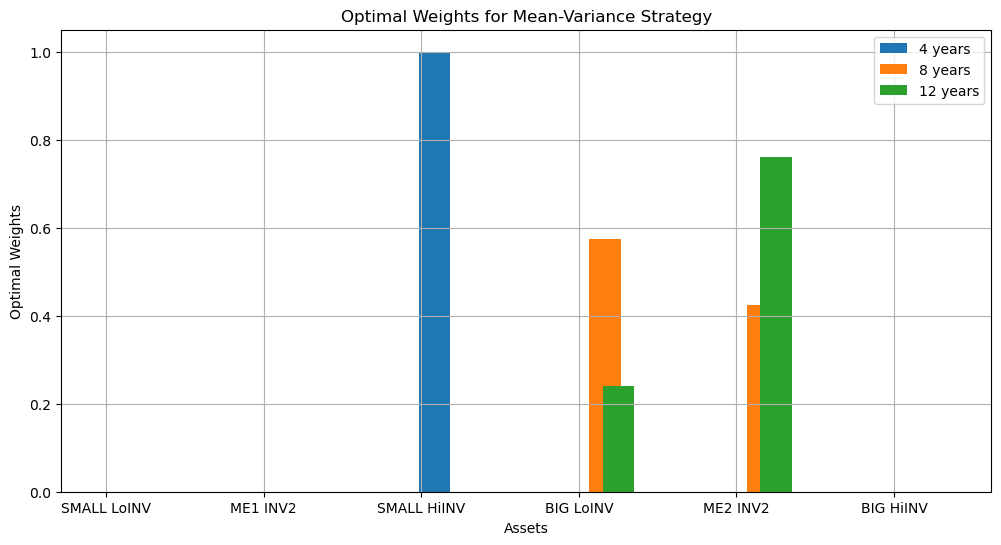

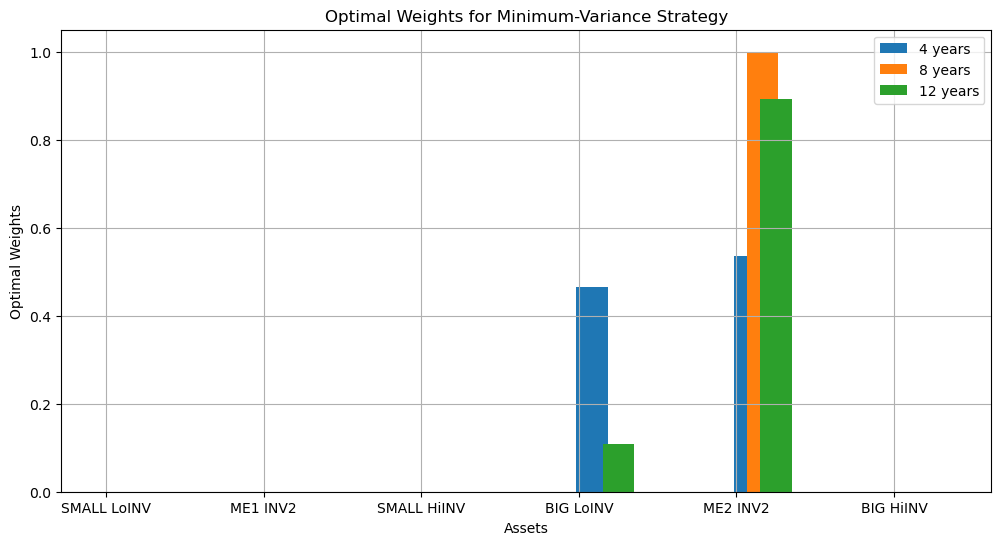

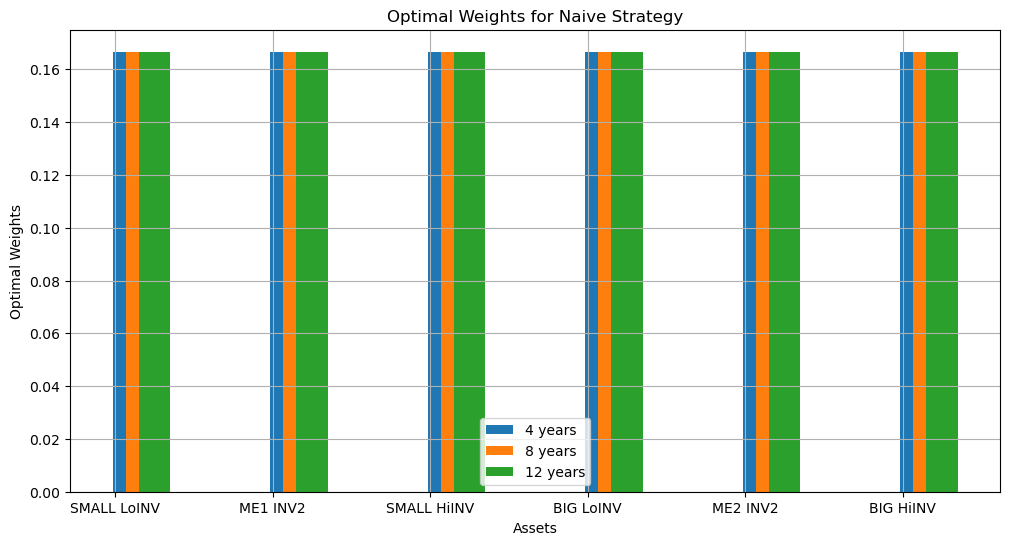

In [45]:

# Assume final_results_df is already defined and contains the optimal weights

def plot_optimal_weights(final_results_df):
    strategies = final_results_df['Strategy'].unique()
    windows = final_results_df['Window'].unique()

    for strategy in strategies:
        plt.figure(figsize=(12, 6))
        for window in windows:
            subset = final_results_df[(final_results_df['Strategy'] == strategy) & (final_results_df['Window'] == window)]
            weights = np.array(subset.iloc[0]['Weights'])
            plt.bar(np.arange(len(weights)) + (window / max(windows) / 4), weights, width=0.2, label=f'{window // 12} years')

        plt.xlabel('Assets')
        plt.ylabel('Optimal Weights')
        plt.title(f'Optimal Weights for {strategy} Strategy')
        plt.legend()
        plt.grid(True)
        plt.xticks(np.arange(len(weights)), ['SMALL LoINV', 'ME1 INV2', 'SMALL HiINV', 'BIG LoINV', 'ME2 INV2', 'BIG HiINV'])
        plt.show()

# Plot optimal weights for each strategy
plot_optimal_weights(final_results_df)



In [46]:

def print_optimal_weights_table(final_results_df):
    table = []

    for window in final_results_df['Window'].unique():
        for strategy in final_results_df['Strategy'].unique():
            subset = final_results_df[(final_results_df['Window'] == window) & (final_results_df['Strategy'] == strategy)]
            if not subset.empty:
                weights = np.round(np.array(subset.iloc[0]['Weights']), 2)
                return_value = np.round(subset.iloc[0]['Return'], 2)
                table.append([window // 12, strategy] + list(weights) + [return_value])
    
    columns = ['Window (Years)', 'Strategy', 'SMALL LoINV', 'ME1 INV2', 'SMALL HiINV', 'BIG LoINV', 'ME2 INV2', 'BIG HiINV', 'Return']
    table_df = pd.DataFrame(table, columns=columns)

    print("Optimal Weights and Returns for Each Strategy and Estimation Window:")
    print(table_df.to_string(index=False))

    return table_df

# Print the optimal weights and returns table
optimal_weights_table = print_optimal_weights_table(final_results_df)

Optimal Weights and Returns for Each Strategy and Estimation Window:
 Window (Years)         Strategy  SMALL LoINV  ME1 INV2  SMALL HiINV  BIG LoINV  ME2 INV2  BIG HiINV  Return
              4    Mean-Variance         0.00      0.00         1.00       0.00      0.00       0.00    1.05
              4 Minimum-Variance         0.00      0.00         0.00       0.46      0.54       0.00    1.29
              4            Naive         0.17      0.17         0.17       0.17      0.17       0.17    1.28
              8    Mean-Variance         0.00      0.00         0.00       0.57      0.43       0.00    0.72
              8 Minimum-Variance         0.00      0.00         0.00       0.00      1.00       0.00    0.84
              8            Naive         0.17      0.17         0.17       0.17      0.17       0.17    0.72
             12    Mean-Variance         0.00      0.00         0.00       0.24      0.76       0.00    0.72
             12 Minimum-Variance         0.00      0.00    

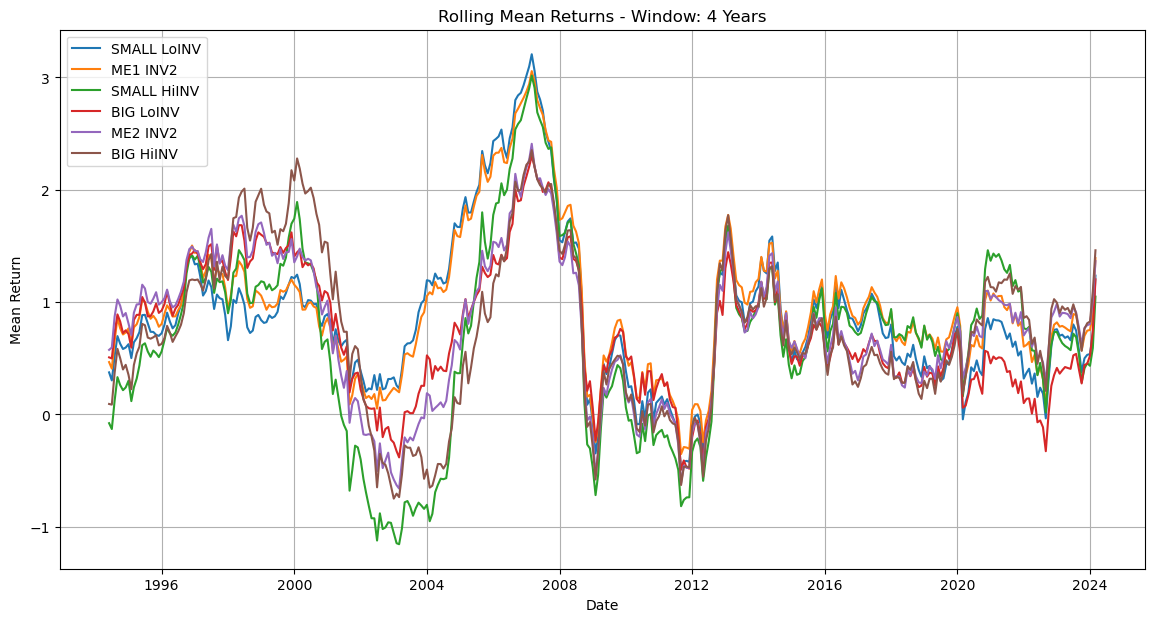

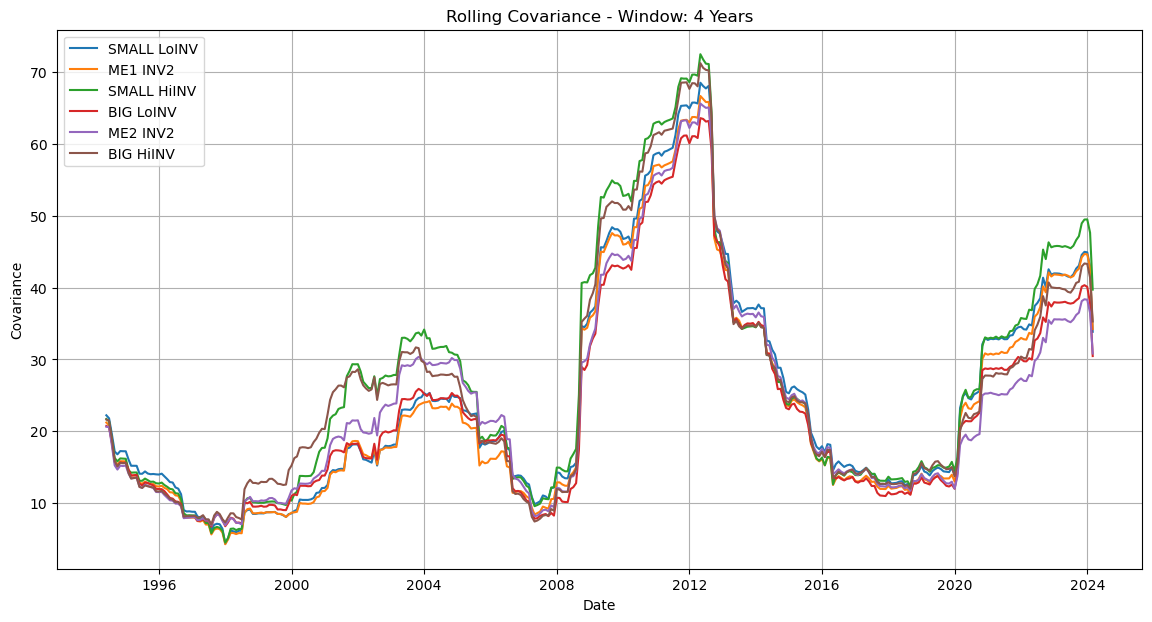

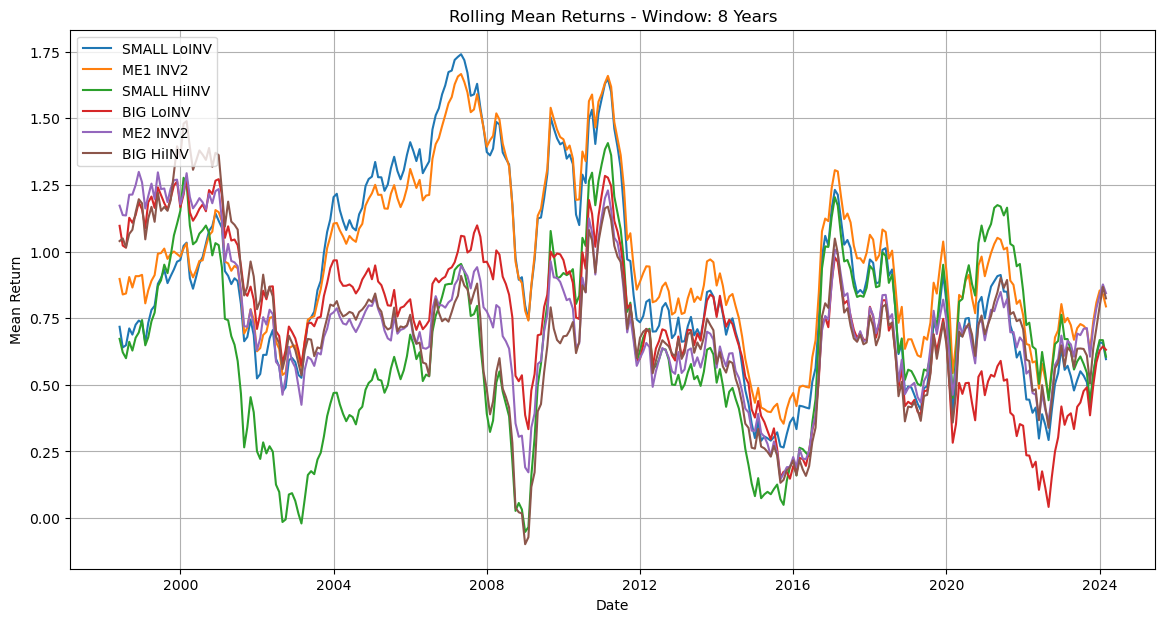

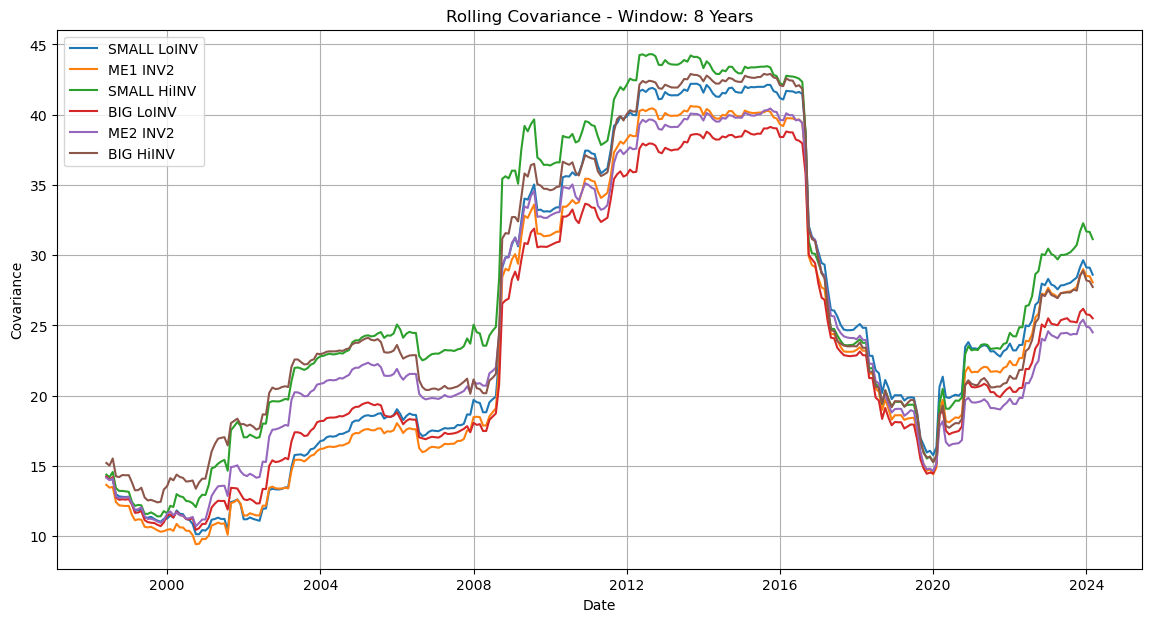

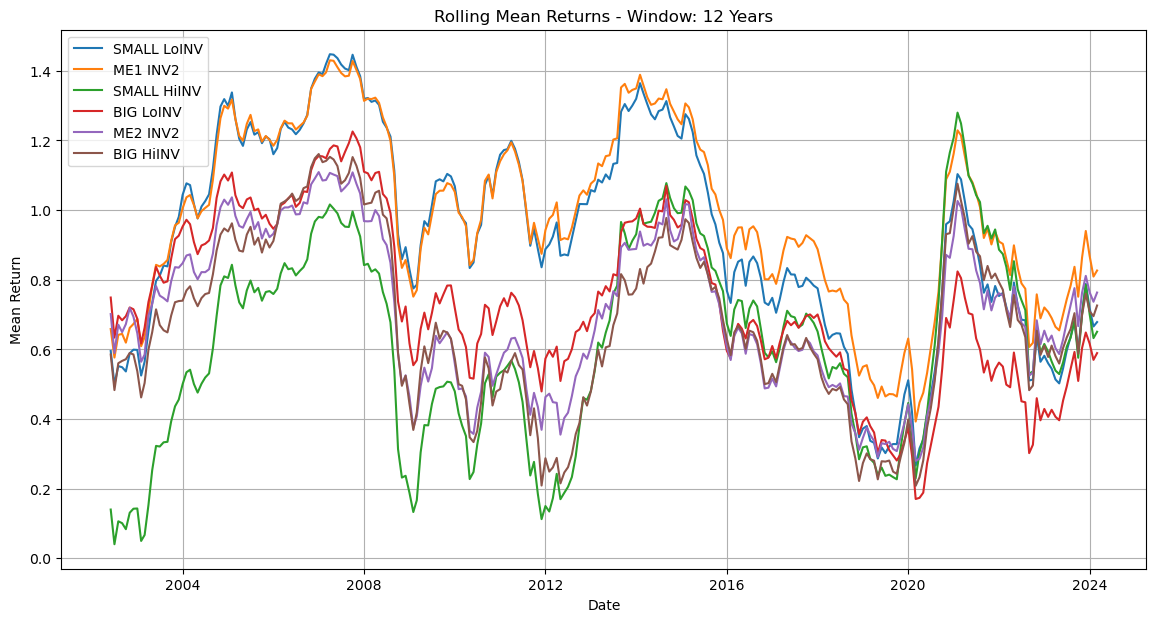

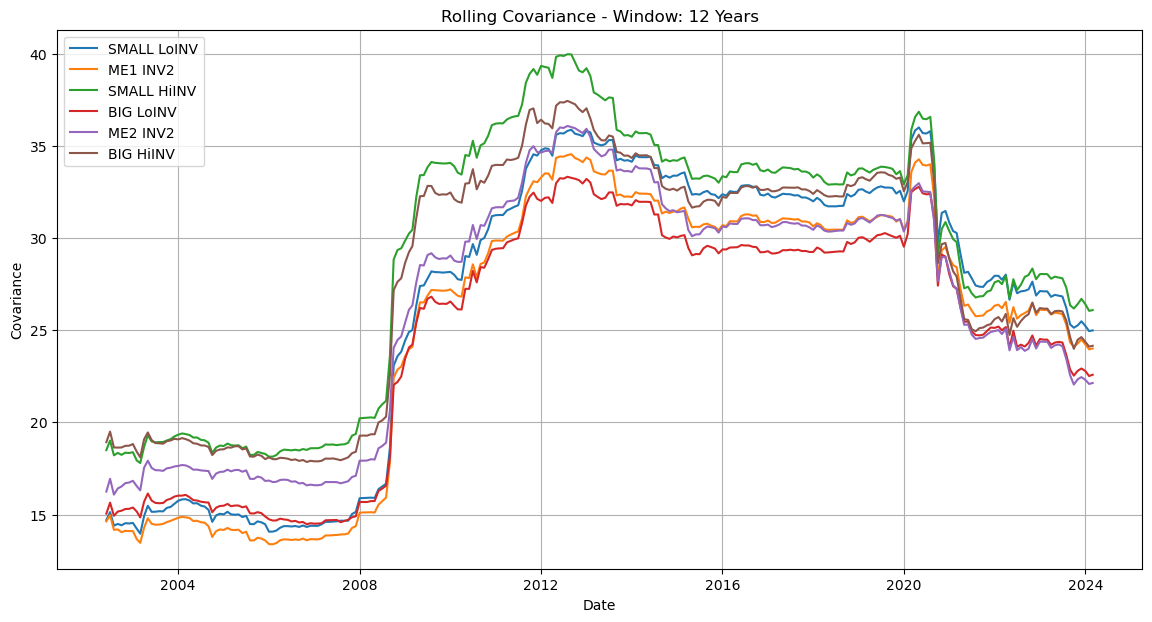

In [47]:
# Function to plot rolling mean and covariance for each window
def plot_rolling_mean_covariance_strategy(data, windows):
    for window in windows:
        rolling_mean = data.rolling(window=window).mean()
        plt.figure(figsize=(14, 7))
        plt.plot(rolling_mean)
        plt.title(f'Rolling Mean Returns - Window: {window // 12} Years')
        plt.xlabel('Date')
        plt.ylabel('Mean Return')
        plt.legend(data.columns, loc='upper left')
        plt.grid(True)
        plt.show()

        rolling_cov = data.rolling(window=window).cov()
        cov_mean = rolling_cov.groupby(level=0).mean()
        plt.figure(figsize=(14, 7))
        plt.plot(cov_mean)
        plt.title(f'Rolling Covariance - Window: {window // 12} Years')
        plt.xlabel('Date')
        plt.ylabel('Covariance')
        plt.legend(data.columns, loc='upper left')
        plt.grid(True)
        plt.show()

# Plot rolling mean and covariance for each window
plot_rolling_mean_covariance_strategy(data, windows)


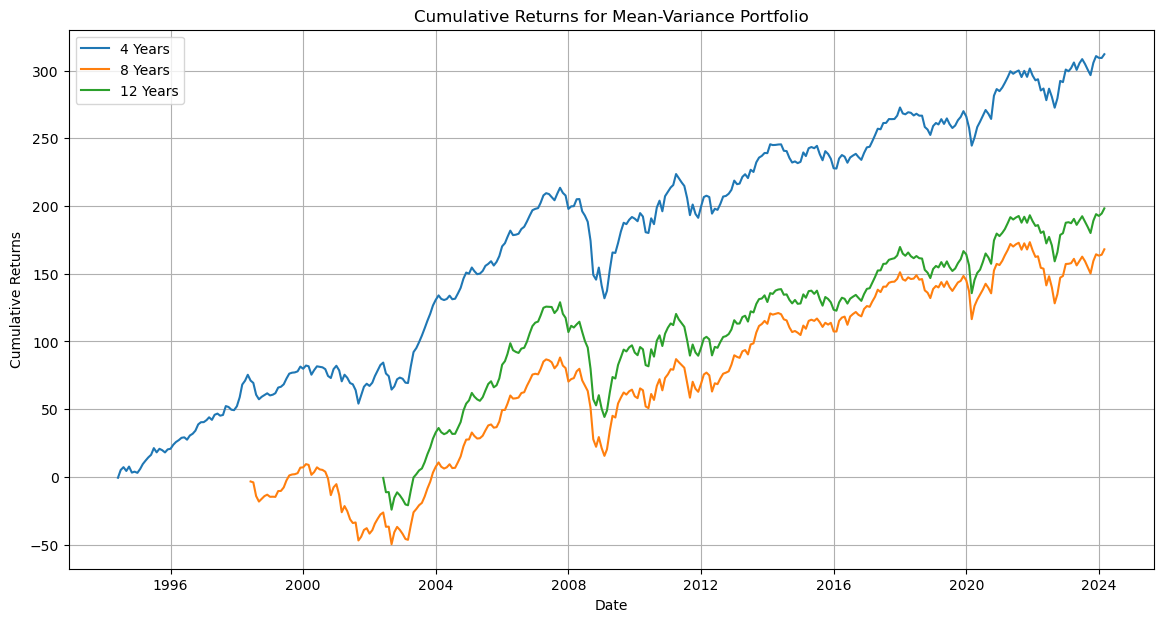

In [34]:
# Function to plot cumulative returns for mean-variance portfolio
def plot_cumulative_returns_mean_variance(results, data, windows):
    plt.figure(figsize=(14, 7))
    for window in windows:
        dates = results[window]['dates']
        mv_weights = results[window]['mv_weights']
        mv_cumulative = np.cumsum([np.dot(w, data.loc[d]) for w, d in zip(mv_weights, dates)])
        plt.plot(dates, mv_cumulative, label=f'{window // 12} Years')
    plt.title('Cumulative Returns for Mean-Variance Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot cumulative returns for mean-variance portfolio
plot_cumulative_returns_mean_variance(results, data, windows)


In [48]:
# Create a DataFrame to store optimal weights and returns
optimal_weights_mean_returns = []

for window in windows:
    last_mean_returns = data.rolling(window=window).mean().dropna().iloc[-1]
    last_cov_matrix = data.rolling(window=window).cov().dropna().iloc[-data.shape[1]:, -data.shape[1]:]
    
    mv_weights = mean_variance_optimization(last_mean_returns, last_cov_matrix, target_return)
    mv_return = np.dot(mv_weights, last_mean_returns)
    mv_std_dev = np.sqrt(np.dot(mv_weights.T, np.dot(last_cov_matrix, mv_weights)))
    
    optimal_weights_mean_returns.append({
        'Window': window // 12,
        'Strategy': 'Mean-Variance',
        'Mean Returns': {key: round(val, 4) for key, val in last_mean_returns.to_dict().items()},
        'Covariance Matrix': np.round(last_cov_matrix.values, 4).tolist(),
        'Weights': np.round(mv_weights, 4).tolist(),
        'Return': round(mv_return, 4),
        'Std Dev': round(mv_std_dev, 4)
    })

# Convert to DataFrame
optimal_weights_mean_returns_df = pd.DataFrame(optimal_weights_mean_returns)

# Print the results
pd.set_option('display.max_columns', None)  # Ensure all columns are printed
print("Optimal Weights and Returns for Mean-Variance Strategy:")
print(optimal_weights_mean_returns_df)

# Save the final results to a CSV file
optimal_weights_mean_returns_df.to_csv('optimal_mean_var_portfolios_results.csv', index=False)


Optimal Weights and Returns for Mean-Variance Strategy:
   Window       Strategy                                       Mean Returns  \
0       4  Mean-Variance  {'SMALL LoINV': 1.2358, 'ME1 INV2': 1.3919, 'S...   
1       8  Mean-Variance  {'SMALL LoINV': 0.5962, 'ME1 INV2': 0.7941, 'S...   
2      12  Mean-Variance  {'SMALL LoINV': 0.6786, 'ME1 INV2': 0.8266, 'S...   

                                   Covariance Matrix  \
0  [[34.578, 34.3542, 39.8516, 30.2217, 30.2036, ...   
1  [[30.5564, 29.4258, 32.5373, 26.4023, 24.8782,...   
2  [[27.0464, 25.4563, 27.524, 23.2775, 22.4269, ...   

                                Weights  Return  Std Dev  
0        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]  1.0490   6.9743  
1  [0.0, 0.0, 0.0, 0.5748, 0.4252, 0.0]  0.7217   4.8718  
2  [0.0, 0.0, 0.0, 0.2392, 0.7608, 0.0]  0.7217   4.6448  


In [49]:
# Create a DataFrame to store optimal weights and returns for minimum-variance problem
optimal_weights_min_variance = []

for window in windows:
    last_mean_returns = data.rolling(window=window).mean().dropna().iloc[-1]
    last_cov_matrix = data.rolling(window=window).cov().dropna().iloc[-data.shape[1]:, -data.shape[1]:]
    
    min_var_weights = minimum_variance_optimization(last_cov_matrix)
    min_var_return = np.dot(min_var_weights, last_mean_returns)
    min_var_std_dev = np.sqrt(np.dot(min_var_weights.T, np.dot(last_cov_matrix, min_var_weights)))
    
    optimal_weights_min_variance.append({
        'Window': window // 12,
        'Strategy': 'Minimum-Variance',
        'Mean Returns': {key: round(val, 4) for key, val in last_mean_returns.to_dict().items()},
        'Covariance Matrix': np.round(last_cov_matrix.values, 4).tolist(),
        'Weights': np.round(min_var_weights, 4).tolist(),
        'Return': round(min_var_return, 4),
        'Std Dev': round(min_var_std_dev, 4)
    })

# Convert to DataFrame
optimal_weights_min_variance_df = pd.DataFrame(optimal_weights_min_variance)

# Print the results
pd.set_option('display.max_columns', None)  # Ensure all columns are printed
print("Optimal Weights and Returns for Minimum-Variance Strategy:")
print(optimal_weights_min_variance_df)

# Save the final results to a CSV file
optimal_weights_min_variance_df.to_csv('optimal_min_var_portfolios_results.csv', index=False)


Optimal Weights and Returns for Minimum-Variance Strategy:
   Window          Strategy  \
0       4  Minimum-Variance   
1       8  Minimum-Variance   
2      12  Minimum-Variance   

                                        Mean Returns  \
0  {'SMALL LoINV': 1.2358, 'ME1 INV2': 1.3919, 'S...   
1  {'SMALL LoINV': 0.5962, 'ME1 INV2': 0.7941, 'S...   
2  {'SMALL LoINV': 0.6786, 'ME1 INV2': 0.8266, 'S...   

                                   Covariance Matrix  \
0  [[34.578, 34.3542, 39.8516, 30.2217, 30.2036, ...   
1  [[30.5564, 29.4258, 32.5373, 26.4023, 24.8782,...   
2  [[27.0464, 25.4563, 27.524, 23.2775, 22.4269, ...   

                                Weights  Return  Std Dev  
0  [0.0, 0.0, 0.0, 0.4648, 0.5352, 0.0]  1.2898   5.3642  
1        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]  0.8436   4.7727  
2  [0.0, 0.0, 0.0, 0.1083, 0.8917, 0.0]  0.7445   4.6419  


In [51]:
# Create a DataFrame to store optimal weights and returns for naive portfolio
optimal_weights_naive = []

for window in windows:
    last_mean_returns = data.rolling(window=window).mean().dropna().iloc[-1]
    last_cov_matrix = data.rolling(window=window).cov().dropna().iloc[-data.shape[1]:, -data.shape[1]:]
    
    naive_weights = naive_portfolio_weights(data)
    naive_return = np.dot(naive_weights, last_mean_returns)
    naive_std_dev = np.sqrt(np.dot(naive_weights.T, np.dot(last_cov_matrix, naive_weights)))
    
    optimal_weights_naive.append({
        'Window': window // 12,
        'Strategy': 'Naive',
        'Mean Returns': {key: round(val, 4) for key, val in last_mean_returns.to_dict().items()},
        'Covariance Matrix': np.round(last_cov_matrix.values, 4).tolist(),
        'Weights': np.round(naive_weights, 4).tolist(),
        'Return': round(naive_return, 4),
        'Std Dev': round(naive_std_dev, 4)
    })

# Convert to DataFrame
optimal_weights_naive_df = pd.DataFrame(optimal_weights_naive)

# Print the results
pd.set_option('display.max_columns', None)  # Ensure all columns are printed
print("Optimal Weights and Returns for Naive Portfolio Strategy:")
print(optimal_weights_naive_df)

# Save the final results to a CSV file
optimal_weights_naive_df.to_csv('optimal_naive_portfolios_results.csv', index=False)


Optimal Weights and Returns for Naive Portfolio Strategy:
   Window Strategy                                       Mean Returns  \
0       4    Naive  {'SMALL LoINV': 1.2358, 'ME1 INV2': 1.3919, 'S...   
1       8    Naive  {'SMALL LoINV': 0.5962, 'ME1 INV2': 0.7941, 'S...   
2      12    Naive  {'SMALL LoINV': 0.6786, 'ME1 INV2': 0.8266, 'S...   

                                   Covariance Matrix  \
0  [[34.578, 34.3542, 39.8516, 30.2217, 30.2036, ...   
1  [[30.5564, 29.4258, 32.5373, 26.4023, 24.8782,...   
2  [[27.0464, 25.4563, 27.524, 23.2775, 22.4269, ...   

                                            Weights  Return  Std Dev  
0  [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]  1.2844   5.8367  
1  [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]  0.7159   5.2534  
2  [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]  0.7058   4.8986  
